In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

from utils.preprocessing import get_dataset_partitions_tf

# Loading data
We would like to load our images in the resoultion 256x256.
We also would like to load them in batches of 32. Loading 32 images then another 32 and so on.
## Constants

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3  # The RGB channels
EPOCHS = 50

The `image_dataset_from_directory` function will load all the images in the folder `data/` and its subfolders

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "data",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE    
)
dataset

Found 2152 files belonging to 3 classes.


<_BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

When images are loaded they are automatically sorted in classes. The classes are the names of the subfolders where the were found.

In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset)

68

**The images were loaded in 68 datasets**

------------------

`dataset.take(1)` takes 1 batch from the dataset and returns a list of tuple of the images in a batch and the labels of those images.
> Since the argument of take is 1, there will be only one iteration

(32, 256, 256, 3)
[1 0 1 0 1 0 1 1 0 1 0 1 1 1 2 1 0 2 2 2 1 1 1 1 0 1 0 0 1 0 1 1]


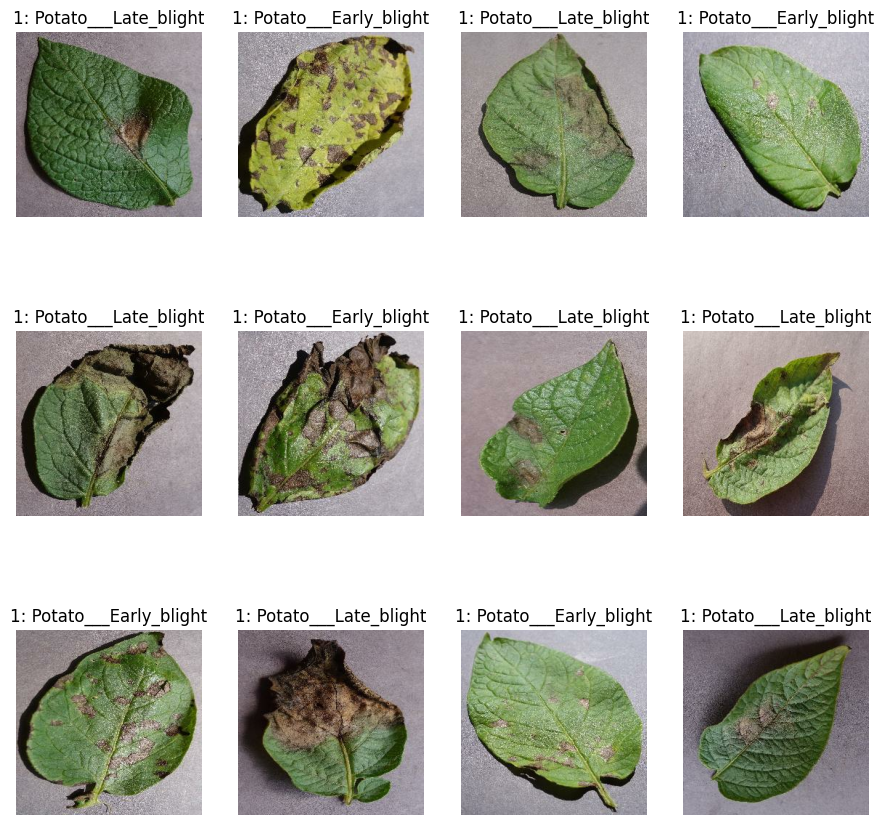

In [6]:
plt.figure(figsize=(11, 11))  # Let's resize the plot so that we can fit more pictures

for image_batch, label_batch in dataset.take(1): 
    print(image_batch.shape)
    print(label_batch.numpy())

    # Let's show the first 12 image in the batch
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)  # Choose the position where to plot in a grid of 3 lines and 4 columns
        plt.imshow(image_batch[i].numpy().astype("uint8"))  # We need to convert to unisigned int of size 8 for it to plot properly
        plt.title("{}: {}".format(label_batch[0], class_names[label_batch[i]]))  # tile is "class number: class name"
        plt.axis("off")  # Remove the axes of the plot. They are not needed when showing an image

**(32, 256, 256, 3) : 32 is the size of the first batch. 256, 256 is the size of the images. 3 are the RGB channels**

# Split Data
We will split our data as follows:

* 70% training data
* 15% cross validation data
* 15% test data

After each epoch, we test our model in the cross validation set and improve it.

After `EPOCHS` number of epochs, we test our model against the test data set.

In [7]:
train_size = 0.7  # 70%
batches_in_training = int(train_size * len(dataset))  # How many batches will be in the training set
batches_in_training

47

In [8]:
# Get the training dataset
train_ds = dataset.take(batches_in_training)

In [9]:
# Get the rest of the batches that were not in the trainining dataset
tmp_test_ds = dataset.skip(batches_in_training)  

In [10]:
cv_size = 0.15  # 15%
batches_in_cv = int(cv_size * len(dataset))
batches_in_cv

10

In [13]:
cv_ds = tmp_test_ds.take(batches_in_cv)  # Training data set takes the number of batches `batches_in_cv`
test_ds = tmp_test_ds.skip(batches_in_cv)  # Test data set takes the rest of the batches

We could get the same result using the function `get_dataset_partition_tf` from the local `utils` package:

In [14]:
train_ds, cv_ds, test_ds = get_dataset_partitions_tf(dataset, train_split=0.7, cv_split=0.15)

In [15]:
len(train_ds)

47

In [16]:
len(cv_ds)

10

In [17]:
len(test_ds)

11

# Prefetch and Cache
Prefetching and caching are techniques used to speed up the training of the model.
They are better explained in the following video:ions



In [23]:
%%HTML
<div align="center">
    <iframe width="560" height="315" 
    src="https://www.youtube.com/embed/MLEKEplgCas?si=nGLgGDZUVV2Fbr3M">
    </iframe>
</div>

In [22]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
cv_ds = cv_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Preprocessing Layers
We'll create 2 small neural networs (we call layers) that will provide resize, rescaling and data augmentation.

## Resize & Rescale:

In [24]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),  # Once the model is implemented in the wild, it won't necessarily be fed images of size 256x256
    layers.Rescaling(1.0/255),  # This layer is added to scale all the features to values between 0 and 1
])

## Data Augmentation
Data Augmentation is a technique used to grow the size of our dataset wihtout having to seek new data. It's well explained in this video:

In [25]:
%%HTML
<div align="center">
    <iframe width="560" height="315" 
    src="https://www.youtube.com/embed/mTVf7BN7S8w?si=ZnGl7BCc7PNhT5-a">
    </iframe>
</div>

Here is the layer (neural network) for data augmentation:

In [26]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),  # Flip randomly
    layers.RandomRotation(0.3)  # The factor of rotation (0.3 of a full rotation in either direction)
])